In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
from sklearn.model_selection import cross_val_score
from joblib import dump, load

In [2]:
SOURCE = 'C:/Users/Cactuar/Documents/'

In [64]:
rating_table = pd.read_csv(SOURCE + 'rating_table.csv')
#player_table = pd.read_csv(SOURCE + 'player_table.csv')
match_table = pd.read_csv(SOURCE + 'match_table.csv')

In [65]:
rating_table = rating_table.drop(columns='prev_id')

In [5]:
#rating_table['bf_rating'].describe()

count    2.071797e+06
mean     2.457830e-03
std      1.623416e-01
min     -1.077224e+00
25%     -5.766116e-02
50%     -2.293546e-02
75%      1.060823e-02
max      2.072944e+00
Name: bf_rating, dtype: float64

In [6]:
#player_table = player_table.rename(columns={'id':'player_id'})

In [66]:
match_table = match_table[match_table['game']=='LotV']

In [39]:
#match_table.head()

In [67]:
match_table['winning_player'] = np.where(match_table['sca'] < match_table['scb'], 'Player B', 'Player A')

In [68]:
match_table = match_table.drop(['sca', 'scb', 'treated','event','eventobj_id','submitter_id','game','offline'], axis=1)

In [69]:
rta_id = match_table[['id','rta_id']]
rtb_id = match_table[['id','rtb_id']]
rta_id = rta_id.merge(rating_table, left_on='rta_id', right_on='id', how='left')
rtb_id = rtb_id.merge(rating_table, left_on='rtb_id', right_on='id', how='left')
rta_id = rta_id.drop(columns='id_y')
rtb_id = rtb_id.drop(columns='id_y')

In [70]:
merged_ratings = rta_id.merge(rtb_id, on='id_x', how='left')
merged_ratings = merged_ratings.rename(columns={'id_x':'id'})

In [71]:
lotv_merged = match_table.merge(merged_ratings, on='id', how='left')
lotv_merged = lotv_merged.drop(columns=['rta_id_x','rtb_id_x','rta_id_y', 'rtb_id_y', 'period_id_y', 'player_id_x', 'player_id_y','id','period_id','date','pla_id','plb_id'])
lotv_merged = lotv_merged.replace(['Z','T','P','R'],[1,2,3,4])
lotv_merged['rca'] = lotv_merged['rca'].astype(str).astype(int)
lotv_merged['rcb'] = lotv_merged['rcb'].astype(str).astype(int)
lotv_merged = lotv_merged.rename(columns={'rca':'player_a_race', 'rcb':'player_b_race', 'bf_rating_x':'player_a_sRating', 'bf_rating_y':'player_b_sRating'})
lotv_merged = lotv_merged.dropna()


In [73]:
lotv_merged.columns.tolist()

['player_a_race',
 'player_b_race',
 'winning_player',
 'period_id_x',
 'rating_x',
 'rating_vp_x',
 'rating_vt_x',
 'rating_vz_x',
 'dev_x',
 'dev_vp_x',
 'dev_vt_x',
 'dev_vz_x',
 'comp_rat_x',
 'comp_rat_vp_x',
 'comp_rat_vt_x',
 'comp_rat_vz_x',
 'player_a_sRating',
 'bf_rating_vp_x',
 'bf_rating_vt_x',
 'bf_rating_vz_x',
 'bf_dev_x',
 'bf_dev_vp_x',
 'bf_dev_vt_x',
 'bf_dev_vz_x',
 'position_x',
 'position_vp_x',
 'position_vt_x',
 'position_vz_x',
 'decay_x',
 'domination_x',
 'rating_y',
 'rating_vp_y',
 'rating_vt_y',
 'rating_vz_y',
 'dev_y',
 'dev_vp_y',
 'dev_vt_y',
 'dev_vz_y',
 'comp_rat_y',
 'comp_rat_vp_y',
 'comp_rat_vt_y',
 'comp_rat_vz_y',
 'player_b_sRating',
 'bf_rating_vp_y',
 'bf_rating_vt_y',
 'bf_rating_vz_y',
 'bf_dev_y',
 'bf_dev_vp_y',
 'bf_dev_vt_y',
 'bf_dev_vz_y',
 'position_y',
 'position_vp_y',
 'position_vt_y',
 'position_vz_y',
 'decay_y',
 'domination_y']

In [74]:
# baseline majority classifier
lotv_merged['winning_player'].value_counts(normalize=True)

Player A    0.626053
Player B    0.373947
Name: winning_player, dtype: float64

In [75]:
train, test = train_test_split(lotv_merged, stratify=lotv_merged['winning_player'], random_state=42)
#train , val = train_test_split(train, stratify=train['winning_player'], random_state=42)

In [76]:
target = 'winning_player'
X_train = train.drop(columns=target)
#X_val = val.drop(columns=target)
X_test = test.drop(columns=target)
y_test = test[target]
y_train = train[target]
#y_val = val[target]

In [62]:
feat = X_test.columns.tolist()
y = lotv_merged[target]
X = lotv_merged[feat]

In [77]:
# search.predict, brier_score~~
#eval_set = [(X_train, y_train), (X_val, y_val)]
model = XGBClassifier(n_estimators=775, max_depth=10, min_child_weight=7, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=7, missing=None,
       n_estimators=775, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [79]:
# pickle model
dump(model, 'alig_predict_model.joblib')

['alig_predict_model.joblib']

In [78]:
print('Train score:', model.score(X_train, y_train))
print('Test score:', model.score(X_test, y_test))

Train score: 0.9853485811520944
Test score: 0.8144658809398694


In [52]:
ypred = model.predict(X_test)
accuracy_score(y_test, ypred)

0.8144658809398694

In [55]:
y_pred_proba = model.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred_proba)

0.8912212671144882

In [56]:
y_pred = model.predict(X_test)
print('test accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

test accuracy: 0.8144658809398694
              precision    recall  f1-score   support

    Player A       0.84      0.88      0.86     16679
    Player B       0.77      0.71      0.74      9963

   micro avg       0.81      0.81      0.81     26642
   macro avg       0.80      0.79      0.80     26642
weighted avg       0.81      0.81      0.81     26642



In [63]:
#takes forever, try StratifiedKfold
#cross_val_score(model, X, y, cv=10, scoring='roc_auc').mean()

0.897600886846868

In [ ]:
#import sklearn
#sorted(sklearn.metrics.SCORERS.keys())

In [ ]:
#results = model.evals_result()
#train_error = results['validation_0']['error']
#val_error = results['validation_1']['error']
#epoch = range(len(train_error))
#plt.plot(epoch, train_error, label='Train')
#plt.plot(epoch, val_error, label='Validation')
#plt.ylim()
#plt.legend();

In [ ]:
#model = XGBClassifier(n_jobs=-1, random_state=42)
#param_dist = {'max_depth': randint(3,12),
#              'learning_rate': uniform(0,1),
#              'n_estimators': randint(200, 1500),
#              'min_child_weight': randint(1,10),
#              'gamma': randint(0,5),
#              'subsample': [0.6, 0.7, 0.8, 0.9, 1],
#              'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1],
#              }
#
#search = RandomizedSearchCV(model,
#                            param_distributions=param_dist,
#                            n_iter=10,
#                            cv=5,
#                            scoring='accuracy',
#                            verbose=10,
#                            return_train_score=True)
#
#search.fit(X_train, y_train)
#print('Best hyperparameters', search.best_params_)
#print('Best score', search.best_score_)

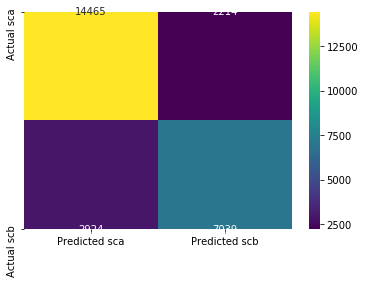

In [25]:
def plot_confusion_matrix(y_true, y_pred):
  labels = unique_labels(y_true)
  columns = [f'Predicted {label}' for label in labels]
  index = [f'Actual {label}' for label in labels]
  table = pd.DataFrame(confusion_matrix(y_true, y_pred),
               columns =columns, index = index)
           
  return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

plot_confusion_matrix(y_test, y_pred);

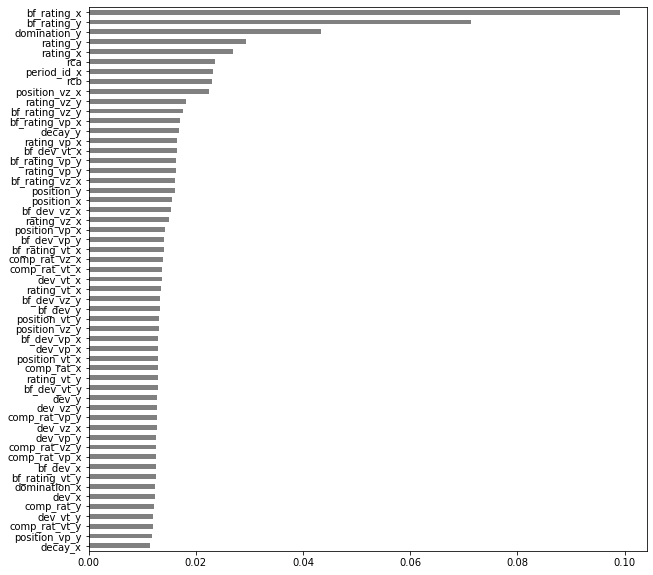

In [26]:
plt.figure(figsize=(10,10))
importances = pd.Series(model.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color='grey');

In [30]:
permuter = PermutationImportance(model, cv='prefit',random_state=42)
permuter.fit(X_val, y_val)
feature_names = X_val.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.3075 ± 0.0040,bf_rating_y
0.2892 ± 0.0033,bf_rating_x
0.1265 ± 0.0034,rating_x
0.1212 ± 0.0036,rating_y
0.0160 ± 0.0023,bf_rating_vz_y
0.0113 ± 0.0023,rating_vz_y
0.0103 ± 0.0018,rca
0.0097 ± 0.0024,bf_rating_vp_x
0.0096 ± 0.0018,rcb
0.0093 ± 0.0023,bf_rating_vz_x
